#HR Separation. 
Checking the annual retirement and separation rates given a model.

In [1]:
coredir = '/data/discovery/hrsepara/core/'
stgdir1 = '/data/discovery/hrsepara/staging/eda'
stgdir1local = '/home/kesj/work/hrsepara/eda'
stgdir2local = '/home/kesj/work/hrsepara/proc'
repodir = '/home/kesj/lib/repo/'

In [2]:
### load the basic files
import os,subprocess,sys
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import chain
import random
import seaborn as sns
from glob import glob
plt.style.use('ggplot')

/opt/anaconda/2.3.0/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/anaconda/2.3.0/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Plan of attack:
1. read the data (after 2001)
2. obtain the set of current employees
3. Run through a model to get prediction(s) for retirement and separation
    * based upon the given model, preprocess it appropriately: for the server model use the minimal set of features and processing of the web_app code.
    * for the survival model ...
4. calc the total separation and retirements for each year and derive the rate of separation/retirement.
    * how do I determine the confidence intervals for these?

In [7]:
os.chdir(stgdir1local)
em2002 = pd.read_csv('employees_after2001_raw.csv',dtype={'EMPL_CLASS':np.str,'LOCATION':np.str,'EEO1CODE':np.str,'SHIFT':np.str,'VOLINVOL':np.str})
em2002.shape
#em2 = pd.read_csv('after2001_v1.csv')
#em2.head()

(134267, 183)

In [11]:
em2.shape

(134266, 164)

## create a few additional target columns
* retired
* separated
* invol_sep

In [15]:
# look at the list of ACTRES1 for  ReTIREMENT
uniq_action_reasons_1 = em2002.ACTRES1.unique()
print len(uniq_action_reasons_1)
temp_list = [str(x).split(';') for x in uniq_action_reasons_1]
from itertools import chain
act_reason_1_list = list(chain.from_iterable(temp_list))
print len(act_reason_1_list)
act_reason_1_set = set(act_reason_1_list)
print len(act_reason_1_set)

# subset these actions into those associated with retirement
possible_retire_codes = [x for x in act_reason_1_set if ('RET' in x and  'RETURN' not in x) ]
possible_retire_codes.append('DISABILITY')
len(possible_retire_codes)
possible_retire_codes.sort()


17459
97164
166


In [16]:
# define a function to identify retired
def identify_retired(x,ret_codes =possible_retire_codes):
    try:
        matched = [a for a in x.split(';') if a in ret_codes]
        if len(matched):
            return 1
        else:
            return 0
    except AttributeError:
        return 0

In [17]:
em2002['retired']= em2002.ACTRES1.apply(lambda x: identify_retired(x))
em2002.retired.value_counts()

0    119149
1     15118
Name: retired, dtype: int64

In [18]:
## create a column for former (i.e. separated but NOT retired)
em2002['former']= 0
my_rows = em2002[(em2002.status==1) & (em2002.retired==0)].index
print "Out of {0} rows, {1} are separated and not retired.".format(len(em2002),len(my_rows))
#sum(empl_df['terminated']))#, len(my_rows)
#em2002.iloc[my_rows,'former']=1
em2002.loc[my_rows,'former']=1#.ix[my_rows]=1
print sum(em2002.former)

Out of 134267 rows, 49674 are separated and not retired.
49674


####There is one case where the person is 'retired' but has status of 0 is wrong -- I'm removing this row.

In [20]:
pd.crosstab(em2002.status, em2002.retired)

retired,0,1
status,,
0,69475,1
1,49674,15117


In [21]:
print len(em2002[~((em2002.status == 0)& (em2002.retired == 1))])
em2002 = em2002[~((em2002.status == 0)& (em2002.retired == 1))]
print len(em2002)

134266
134266


In [22]:
## save this dataframe
os.chdir(stgdir2local)
em2002.to_csv('after2001_keyed.csv',index=False)

# Start here April 15, 2016

In [9]:
warning_cols = [42,47,92,165,178]
[em2002.columns[a] for a in warning_cols]

['EEO1CODE', 'EMPL_CLASS', 'LOCATION', 'SHIFT', 'VOLINVOL']

In [10]:
os.chdir(stgdir2local)
em2002 = pd.read_csv('after2001_keyed.csv',dtype={'EMPL_CLASS':np.str,'LOCATION':np.str,'EEO1CODE':np.str,'SHIFT':np.str,'VOLINVOL':np.str})

## first define the current employees

In [11]:
current = em2002[em2002.status==0].copy() 

In [12]:
np.shape(current)

(69475, 185)

## now look to apply the HRserver model (reduced column)

In [25]:
cols_to_keep = ['KEY','HIRE_DT','BIRTHDATE','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP']


In [68]:
employee_df = current[cols_to_keep].copy()

In [69]:
employee_df.isnull().any()

KEY          False
HIRE_DT      False
BIRTHDATE    False
SAL1         False
MERIT1        True
PERF1         True
BOX1          True
SEX          False
HAVE_INS      True
HAVE_DEP      True
dtype: bool

In [70]:
# get the current date
import datetime
today_timestamp = pd.to_datetime(datetime.datetime.today())
print today_timestamp
# replace with Jan 01-15
today_timestamp =pd.to_datetime(datetime.datetime.strptime('01JAN2015','%d%b%Y'))
print today_timestamp

2015-11-02 08:45:24.371272
2015-01-01 00:00:00


In [71]:
def calculate_years(timestamp1,timestamp2,days_in_year =365.25):
    number_of_years = (timestamp2 - timestamp1).days/days_in_year
    return number_of_years

In [72]:
## create timestamps for columns that are timestamps

employee_df[['hire_tstmp','birth_tstmp']] = employee_df[['HIRE_DT','BIRTHDATE']].applymap(lambda x: pd.to_datetime(datetime.datetime.strptime(x,'%d%b%Y')))
employee_df[['Age_years','Tenure_years']] = employee_df[['birth_tstmp','hire_tstmp']].applymap(lambda x: calculate_years(x,today_timestamp))

# now deal with the the rest of the columns (map using the above  )
columns_for_modeling = ['Age_years','Tenure_years','SAL1','MERIT1','PERF1','BOX1','SEX','HAVE_INS','HAVE_DEP',]
    #'EMPL_TYPE']
# replace Y with 1 and N with 0
# replace M with 1 and F with 0 (in SEX)


In [73]:
empl=employee_df[columns_for_modeling].copy()
empl.fillna({'HAVE_INS':'N','HAVE_DEP':'N','BOX1':0,'MERIT1':0.0,'PERF1':0.0,'SAL1':0.0},inplace=True)
empl.isnull().any()


Age_years       False
Tenure_years    False
SAL1            False
MERIT1          False
PERF1           False
BOX1            False
SEX             False
HAVE_INS        False
HAVE_DEP        False
dtype: bool

In [74]:
## replace specific elements based upon dictionary
replace_dict = {'HAVE_INS': {'Y':1,'N':0}, 'HAVE_DEP': {'Y':1,'N':0}, 'BOX1':{'H':3,'S':2,'L':1},'SEX':{'M':1,'F':0}}
for key,value in replace_dict.iteritems():
    empl[key].replace(value,inplace=True)


In [75]:
# fix the dollar amounts
min_sal1 = 17621.76 #(based upon training set I have: 5 %tile cut off)
min_min_rt_ann = 17900. # same as above
min_max_rt_ann = 33155.70

max_max_rt_ann = 133068.91
min_merit1 = 0.0
min_perf1 = 0.0
fix_min_outlier_col_dict = {'SAL1': min_sal1, 'MERIT1': min_merit1, 'PERF1': min_perf1}
fix_max_outlier_col_dict = {'MAX_RT_ANNUAL': max_max_rt_ann}

# replace these values
for key,value in fix_min_outlier_col_dict.iteritems():        
    idx_to_replace = empl[empl[key]<value].index
    empl.loc[idx_to_replace,key]=value

    # dummy empl_type categories
    #empl_type_dummy_cat = ['EMPL_TYPE_E', 'EMPL_TYPE_H', 'EMPL_TYPE_N', 'EMPL_TYPE_S', 'EMPL_TYPE_X', 'EMPL_TYPE_nan']


In [76]:
X = empl.as_matrix()

In [77]:
np.shape(X)

(69475, 9)

In [41]:
# define the application of a series of time-based model
def apply_time_models(X,MODEL_BASE_PATH,pcase,pred_years):
    proba_df = []


    import joblib as jl
    import pandas as pd

    for idx,pyr in enumerate(pred_years):
        pkl_name ='rf'+pyr+'.pkl'#5.pkl'
        if pcase == 'ret/':
            pkl_name = 'R'+pkl_name

        path_name =MODEL_BASE_PATH+pcase+pyr+'/'
        print path_name, pkl_name

        # load a model, evaluate it and return the 'average' probability for each person
        #abs_mdl_name = os.path.abspath(path_name+pkl_name)
        mdl_name = path_name+pkl_name
        stored_mdl = jl.load(mdl_name)
        stored_prediction = evaluate_models(stored_mdl,X)#stored_pred,stored_pred_proba = evaluate_models(stored_mdl,X)

        df = pd.DataFrame(stored_prediction.T)
        df.columns=[pcase[:-1]+pyr+'yr']

        proba_df.append(df)

    pred_df = pd.concat([a for a in proba_df], axis=1)
    return pred_df

# define a function to apply a set of models to a given prediction
## now apply each model to my eval set
def evaluate_models(model_list,X,mode='mean',offset=0):
    """ Function to apply a set of models to a given input and generate the predicted value(s)
    :param model_list --> input list of models
    :param X --> input array to apply models to
    :param mode --> what sort of output to return; default is mean
    intermediates
        eval_pred_class --> array of classification prediction for each model
        eval_pred_proba --> array of predicted probabilities for each model
    """
    import numpy as np
    eval_pred_class = np.zeros((len(X),len(model_list)))
    eval_pred_proba = np.zeros((len(X),2,len(model_list)))

    for i,mdl in enumerate(model_list):
        eval_proba = mdl.predict_proba(X)
        eval_pred_class[:,i]=mdl.predict(X)
        eval_pred_proba[:,:,i]=eval_proba
    if mode == 'mean':
        # average the probabilities (for class=1) and return the mean predicted probability
        prediction = np.mean(eval_pred_proba[:,1,:],axis=1)
        #eval_pred_proba[:,1,:].mean(axis=2)

    elif mode == 'class': # return the desired class prediction
        prediction = map(np.int,eval_pred_class.mean(axis=1))
    return prediction


In [78]:
# load the model
MODEL_BASE_PATH = '/home/kesj/projects/hrsepara/model/'
#MODEL_BASE_PATH = 'C:\\Users\\kesj\\code\\hrsep1\\model_1\\'
pred_cases = ['sep/','ret/']
pred_years = map(np.str,np.arange(1,6))

sep_proba_df = apply_time_models(X,MODEL_BASE_PATH,pred_cases[0],pred_years)
ret_proba_df = apply_time_models(X,MODEL_BASE_PATH,pred_cases[1],pred_years)
sep_proba_df.index=employee_df.KEY
ret_proba_df.index=employee_df.KEY

/home/kesj/projects/hrsepara/model/sep/1/ rf1.pkl
/home/kesj/projects/hrsepara/model/sep/2/ rf2.pkl
/home/kesj/projects/hrsepara/model/sep/3/ rf3.pkl
/home/kesj/projects/hrsepara/model/sep/4/ rf4.pkl
/home/kesj/projects/hrsepara/model/sep/5/ rf5.pkl
/home/kesj/projects/hrsepara/model/ret/1/ Rrf1.pkl
/home/kesj/projects/hrsepara/model/ret/2/ Rrf2.pkl
/home/kesj/projects/hrsepara/model/ret/3/ Rrf3.pkl
/home/kesj/projects/hrsepara/model/ret/4/ Rrf4.pkl
/home/kesj/projects/hrsepara/model/ret/5/ Rrf5.pkl


## now check on the rates of retirements for each of the coming years
* calculate the total number of retirements and rate of retirement.
    * option 1: sum the probabilities
    * option 2: apply a threshold and sum in binary way.
    

In [79]:
np.shape(ret_proba_df), np.shape(sep_proba_df)

((69475, 5), (69475, 5))

In [80]:
sep_proba_df.head()

,sep1yr,sep2yr,sep3yr,sep4yr,sep5yr
KEY,,,,,
929965184037557,0.076923,0.170833,0.238182,0.473,0.570000
2396741883083,0.104615,0.200000,0.410000,0.535,0.610000
872454415016088,0.050769,0.089167,0.171818,0.205,0.298889
247046588569436,0.051538,0.134167,0.208182,0.253,0.393333
797202090638318,0.060769,0.142500,0.248182,0.385,0.542222


In [86]:
simple_rates = pd.DataFrame(sep_proba_df.sum()/float(len(sep_proba_df)))
simple_rates.index = ['yr1','yr2','yr3','yr4','yr5']
simple_rates.columns = ['Separation']
simple_rates['Annual Separation'] = simple_rates.diff()
simple_rates.loc['yr1','Annual Separation']= simple_rates.loc['yr1','Separation']

In [88]:
tmp_rates = pd.DataFrame(ret_proba_df.sum()/float(len(ret_proba_df)))
tmp_rates.index = ['yr1','yr2','yr3','yr4','yr5']
tmp_rates.columns = ['Retirement']
tmp_rates['Annual Retirement'] = tmp_rates.diff()
tmp_rates.loc['yr1','Annual Retirement']= tmp_rates.loc['yr1','Retirement']
simple_rates = pd.concat([simple_rates,tmp_rates],axis=1)
simple_rates

,Separation,Annual Separation,Retirement,Annual Retirement
yr1,0.076805,0.076805,0.250447,0.250447
yr2,0.130035,0.053230,0.129878,-0.120569
yr3,0.173409,0.043374,0.173168,0.043290
yr4,0.213233,0.039824,0.211291,0.038122
yr5,0.251367,0.038134,0.251376,0.040085


## what were historical rates?

In [89]:
### load in the federal unemployment data
unempl_raw = pd.read_csv('../eda/us_unemployment_monthly_seas.csv')
unempl_raw.head()
### convert to useable format
unempl = pd.melt(unempl_raw, id_vars='Year')
unempl.sort('Year', inplace=True)
unempl['date'] = unempl[['Year','variable']].apply(lambda x: pd.to_datetime(x[1]+str(x[0]),format='%b%Y'),axis=1)
unempl.sort('date',inplace=True)
unempl.head()

/home/kesj/envs/cutting/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/kesj/envs/cutting/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Year,variable,value,date
0,1987,Jan,6.6,1987-01-01
29,1987,Feb,6.6,1987-02-01
58,1987,Mar,6.6,1987-03-01
87,1987,Apr,6.3,1987-04-01
116,1987,May,6.3,1987-05-01


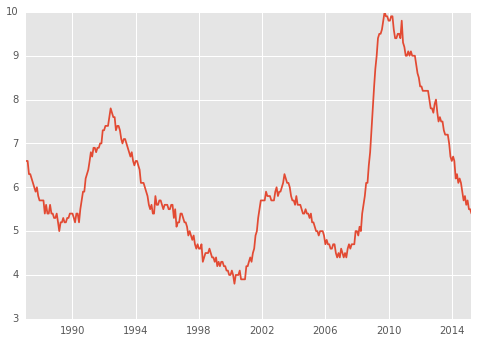

In [95]:
plt.plot(unempl.date,unempl.value)

In [96]:
unempl.groupby('Year')['value'].mean()

Year
1987    6.175000
1988    5.491667
1989    5.258333
1990    5.616667
1991    6.850000
1992    7.491667
1993    6.908333
1994    6.100000
1995    5.591667
1996    5.408333
1997    4.941667
1998    4.500000
1999    4.216667
2000    3.966667
2001    4.741667
2002    5.783333
2003    5.991667
2004    5.541667
2005    5.083333
2006    4.608333
2007    4.616667
2008    5.800000
2009    9.283333
2010    9.608333
2011    8.941667
2012    8.066667
2013    7.366667
2014    6.150000
2015    5.525000
Name: value, dtype: float64

## calculate the historical rates of retirement and separation

In [102]:
em2002[['hire_tstmp','term_tstmp']] = em2002[['HIRE_DT','TERMINATION_DT']].applymap(lambda x: pd.to_datetime(datetime.datetime.strptime(x,'%d%b%Y')))


,hire_tstmp
0,1974-06-03
1,1976-07-06
2,1974-05-06
3,1964-02-10
4,1949-11-16
5,1960-06-11
6,1956-06-19
7,1985-10-12
8,1967-07-03
9,1959-12-22


In [104]:
monthly_range_terminations = pd.date_range(em2002.term_tstmp.min(),em2002.term_tstmp.max(),freq='M')
print len(monthly_range_terminations)
monthly_range_terminations

156


DatetimeIndex(['2002-01-31', '2002-02-28', '2002-03-31', '2002-04-30',
               '2002-05-31', '2002-06-30', '2002-07-31', '2002-08-31',
               '2002-09-30', '2002-10-31',
               ...
               '2014-03-31', '2014-04-30', '2014-05-31', '2014-06-30',
               '2014-07-31', '2014-08-31', '2014-09-30', '2014-10-31',
               '2014-11-30', '2014-12-31'],
              dtype='datetime64[ns]', length=156, freq='M')

In [106]:
monthly_range_terminations[0]-1

Timestamp('2001-12-31 00:00:00', offset='M')

In [111]:
len(em2002[(em2002.term_tstmp <= monthly_range_terminations[1]) & (em2002.retired == 0) & (em2002.term_tstmp > monthly_range_terminations[0])])

291

In [112]:
nactive = []
nsep2 = []
nhired = []
nretired = []
prev_date = monthly_range_terminations[0]-1
#nsep.append(0.0)
for idx, my_date in enumerate(monthly_range_terminations):
    nactive.append( len(em2002[(em2002.hire_tstmp < my_date) &(em2002.term_tstmp > my_date)]))
    if idx == 0:
        nsep2.append(len(em2002[(em2002.term_tstmp <= my_date) & (em2002.hire_tstmp < my_date)]))
        nretired.append(len(em2002[(em2002.term_tstmp <= my_date) & (em2002.hire_tstmp < my_date) & (em2002.retired==1)]))
        nhired.append( len(em2002[(em2002.hire_tstmp <= my_date) &(em2002.hire_tstmp > prev_date)]))
    else:
        nsep2.append(len(em2002[(em2002.term_tstmp <= my_date) & (em2002.hire_tstmp < my_date) &( em2002.term_tstmp > monthly_range_terminations[idx-1])]))
        nretired.append(len(em2002[(em2002.term_tstmp <= my_date) & (em2002.hire_tstmp < my_date) & (em2002.retired==1) &( em2002.term_tstmp > monthly_range_terminations[idx-1])]) )
        nhired.append( len(em2002[(em2002.hire_tstmp <= my_date) &(em2002.hire_tstmp > monthly_range_terminations[idx-1])]))
        

In [114]:
workforce= pd.DataFrame(data =nactive,index=monthly_range_terminations,columns=['Active'])
delta = workforce.diff()
workforce['netChange'] = delta
workforce['AllSeparations'] = nsep2
workforce['Hires'] = nhired
workforce['Retirements'] = nretired
workforce.head()

,Active,netChange,AllSeparations,Hires,Retirements
2002-01-31,78265,NaN,370,470,41
2002-02-28,78270,5,330,336,39
2002-03-31,78142,-128,398,268,39
2002-04-30,78102,-40,323,284,39
2002-05-31,78145,43,469,514,80


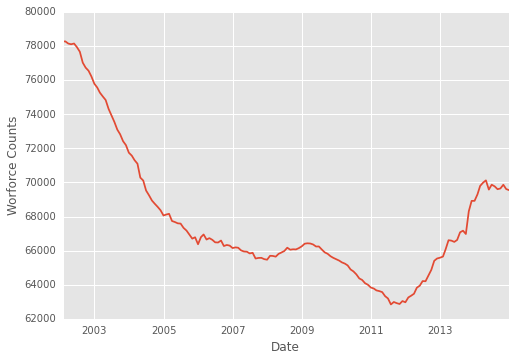

In [115]:
plt.plot(monthly_range_terminations,nactive)
plt.xlabel('Date')
plt.ylabel('Worforce Counts')

In [116]:
annualwf = pd.DataFrame()
annualwf = workforce[['AllSeparations','Hires','Retirements']].resample('A',how='sum')#.plot()
annualwf['Active'] =workforce['Active'].resample('A',how='last')
annualwf.head()

,AllSeparations,Hires,Retirements,Active
2002-12-31,5740,3365,646,75790
2003-12-31,6095,2046,1159,71742
2004-12-31,6849,3166,1940,68058
2005-12-31,6534,4860,1501,66373
2006-12-31,5303,5068,1376,66149


In [ ]:
annualwf['Separations']=annualwf['AllSeparations']-annualwf['Retirements']
annualwf['SepRate']=annualwf['Separations']/annualwf['Active']
annualwf['RetRate']=annualwf['Separations']/annualwf['Active']


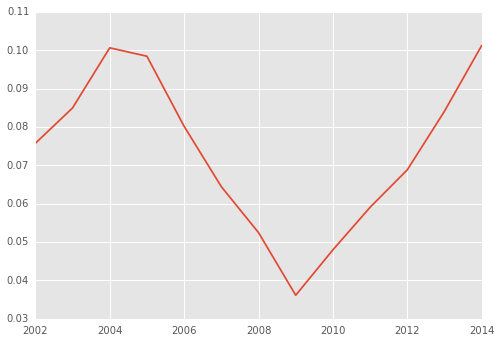

In [119]:
(annualwf.AllSeparations/annualwf.Active).plot()